<a href="https://colab.research.google.com/github/Zonner93/cnn-python-keras/blob/main/cnn_missile_vs_fighter_jet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Klasyfikator binarny - Pocisk czy Myśliwiec

### Czyszczenie katalogu roboczego



In [1]:
!ls

sample_data


In [2]:
!rm -rf sample_data/

### Importowanie bibliotek

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

### Pobieranie danych

In [4]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2022-01-28 16:14:56--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G  63.6MB/s    in 21s     

2022-01-28 16:15:19 (68.9 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



### Przygotowanie zbiorów: treningowego, walidacyjnego oraz testowego

In [ ]:
# !rm -rf ./images

In [5]:
BASE_DIR = './data/planes'
raw_number_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_number_of_files[dir] = len(os.listdir(os.path.join(BASE_DIR, dir)))

raw_number_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [6]:
DATA_DIR = './images'

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

train_dir = os.path.join(DATA_DIR, 'train')  # ścieżka do katalogu danych trenujących
valid_dir = os.path.join(DATA_DIR, 'valid')  # ścieżka do katalogu danych walidacyjnych
test_dir = os.path.join(DATA_DIR, 'test')  # ścieżka do katalogu danych testujących

train_fighter_dir = os.path.join(train_dir, 'fighter')
train_missile_dir = os.path.join(train_dir, 'missile')

valid_fighter_dir = os.path.join(valid_dir, 'fighter')
valid_missile_dir = os.path.join(valid_dir, 'missile')

test_fighter_dir = os.path.join(test_dir, 'fighter')
test_missile_dir = os.path.join(test_dir, 'missile')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_fighter_dir,
        train_missile_dir,
        valid_fighter_dir,
        valid_missile_dir,
        test_fighter_dir,
        test_missile_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [7]:
missile_file_names = os.listdir(os.path.join(BASE_DIR, 'missile'))
fighter_file_names = os.listdir(os.path.join(BASE_DIR, 'fighter-jet'))

missile_file_names = [fname for fname in missile_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
fighter_file_names = [fname for fname in fighter_file_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [8]:
size = min(len(missile_file_names), len(fighter_file_names))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [9]:
for i, file_name in enumerate(missile_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'missile', file_name)
        dst = os.path.join(train_missile_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'missile', file_name)
        dst = os.path.join(valid_missile_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'missile', file_name)
        dst = os.path.join(test_missile_dir, file_name)
        shutil.copyfile(src, dst)

for i, file_name in enumerate(fighter_file_names):
    if i <= train_idx:
        src = os.path.join(BASE_DIR, 'fighter-jet', file_name)
        dst = os.path.join(train_fighter_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(BASE_DIR, 'fighter-jet', file_name)
        dst = os.path.join(valid_fighter_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(BASE_DIR, 'fighter-jet', file_name)
        dst = os.path.join(test_fighter_dir, file_name)
        shutil.copyfile(src, dst)

print('missile - zbiór treningowy', len(os.listdir(train_missile_dir)))
print('missile - zbiór walidacyjny', len(os.listdir(valid_missile_dir)))
print('missile - zbiór testowy', len(os.listdir(test_missile_dir)))

print('fighter - zbiór treningowy', len(os.listdir(train_fighter_dir)))
print('fighter - zbiór walidacyjny', len(os.listdir(valid_fighter_dir)))
print('fighter - zbiór testowy', len(os.listdir(test_fighter_dir)))

missile - zbiór treningowy 921
missile - zbiór walidacyjny 263
missile - zbiór testowy 131
fighter - zbiór treningowy 921
fighter - zbiór walidacyjny 263
fighter - zbiór testowy 131


### Eksploracja danych

(-0.5, 429.5, 259.5, -0.5)

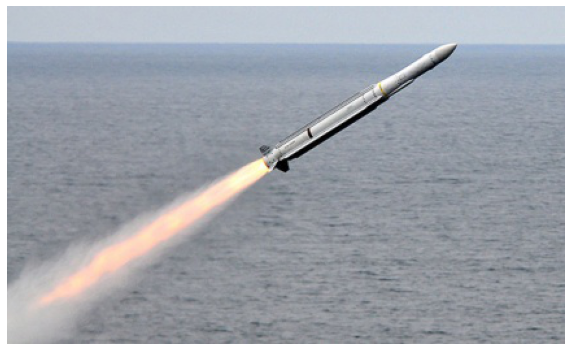

In [16]:
# @title Wybierz indeks przykładowego zdjęcia pocisku ze zbioru treningowego:

idx = 511  # @param {type:'slider', min:0, max:920}
names_mapping = dict(enumerate(missile_file_names))
img_path = os.path.join(train_missile_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 601.5, 375.5, -0.5)

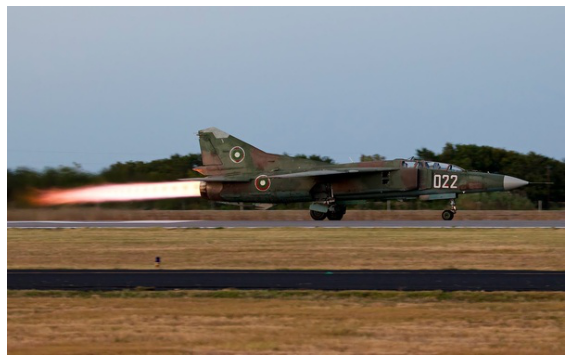

In [33]:
# @title Wybierz indeks przykładowego zdjęcia myśliwca ze zbioru treningowego:

idx = 789  # @param {type:'slider', min:0, max:920}
names_mapping = dict(enumerate(fighter_file_names))
img_path = os.path.join(train_fighter_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### Augmentacja danych

In [27]:
train_data_generator = ImageDataGenerator(
    rotation_range=40,  # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1. / 255.,  # skalowanie
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2,  # poziome przekształcenia obrazu
    shear_range=0.2,  # zares losowego przycianania obrazu
    zoom_range=0.2,  # zakres losowego przybliżania obrazu
    horizontal_flip=True,  # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'  # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_data_generator = ImageDataGenerator(rescale=1. / 255.)

train_generator = train_data_generator.flow_from_directory(directory=train_dir,
                                                           target_size=(150, 150),
                                                           batch_size=32,
                                                           class_mode='binary')

valid_generator = valid_data_generator.flow_from_directory(directory=valid_dir,
                                                           target_size=(150, 150),
                                                           batch_size=32,
                                                           class_mode='binary')


Found 1842 images belonging to 2 classes.
Found 526 images belonging to 2 classes.


In [28]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    file_names = [os.path.join(directory, file_name) for file_name in os.listdir(directory)]
    img_path = file_names[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_data_generator.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

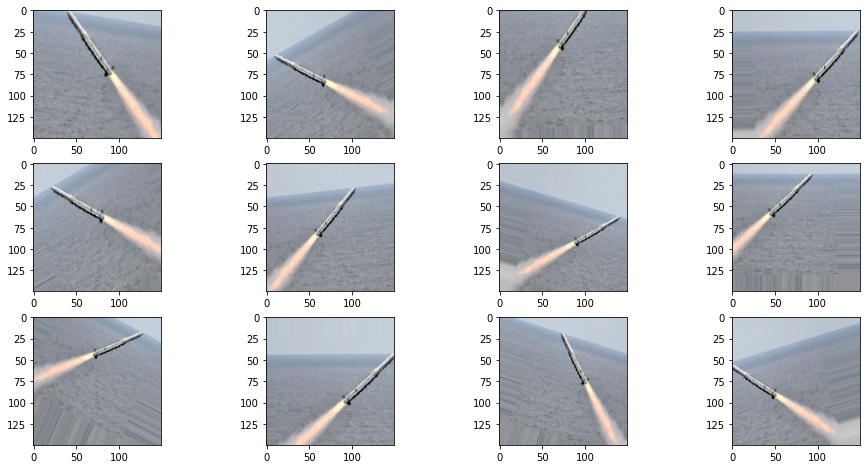

In [29]:
# @title Zbiór treningowy pocisku:
idx = 511  # @param {type:'slider', min:0, max:920}
display_augmented_images(train_missile_dir, idx)

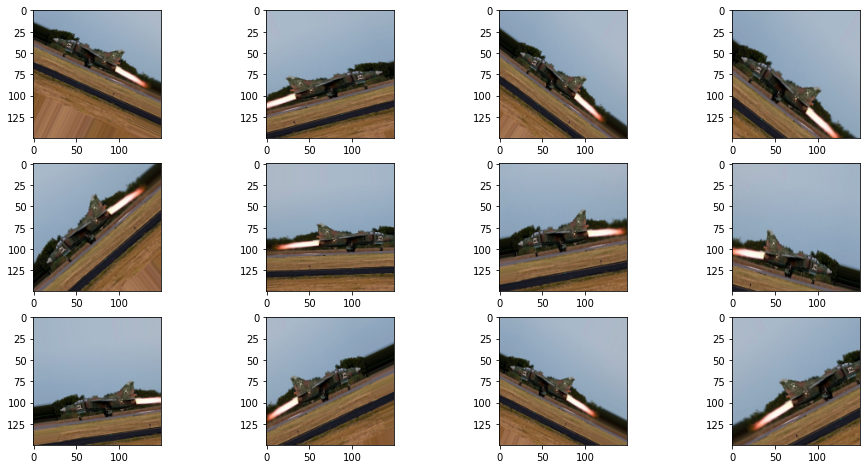

In [34]:
# @title Zbiór treningowy myśliwca:
idx = 789  # @param {type:'slider', min:0, max:920}
display_augmented_images(train_fighter_dir, idx)

### Budowa modelu

In [35]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [37]:
!rm -rf logs
!mkdir logs
tensorboard = TensorBoard(log_dir='logs')

In [40]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/30
28/28 [==============================] - 24s 831ms/step - loss: 0.6769 - accuracy: 0.5859 - val_loss: 0.6506 - val_accuracy: 0.6445
Epoch 2/30
28/28 [==============================] - 24s 860ms/step - loss: 0.6696 - accuracy: 0.6043 - val_loss: 0.6510 - val_accuracy: 0.5781
Epoch 3/30
28/28 [==============================] - 22s 801ms/step - loss: 0.6607 - accuracy: 0.6281 - val_loss: 0.6332 - val_accuracy: 0.6953
Epoch 4/30
28/28 [==============================] - 21s 758ms/step - loss: 0.6458 - accuracy: 0.6236 - val_loss: 0.6961 - val_accuracy: 0.5977
Epoch 5/30
28/28 [==============================] - 23s 825ms/step - loss: 0.6522 - accuracy: 0.6383 - val_loss: 0.6268 - val_accuracy: 0.6641
Epoch 6/30
28/28 [==============================] - 21s 758ms/step - loss: 0.6314 - accuracy: 0.6587 - val_loss: 0.6426 - val_accuracy: 0.6328
Epoch 7/30
28/28 [==============================] - 22s 811ms/step - loss: 0.6313 - accuracy: 0.6361 - val_loss: 0.6131 - val_accuracy: 0.6914

In [41]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki',
                      yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss',
                      yaxis_type='log')
    fig.show()


plot_hist(history)

### Ocena modelu na zbiorze testowym

In [43]:
test_data_generator = ImageDataGenerator(rescale=1. / 255.)
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 262 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([0.154518, 0.617732, 0.46164 , 0.155225, 0.225394, 0.587822,
       0.384326, 0.51719 , 0.815468, 0.355885, 0.188467, 0.35955 ,
       0.332134, 0.711503, 0.324542, 0.265007, 0.380841, 0.407189,
       0.423694, 0.424296, 0.658032, 0.413948, 0.381951, 0.298184,
       0.416352, 0.120546, 0.236721, 0.323774, 0.537916, 0.56345 ,
       0.440798, 0.430403, 0.403606, 0.202749, 0.194077, 0.100554,
       0.232437, 0.310727, 0.329794, 0.376027, 0.341447, 0.165817,
       0.677811, 0.174058, 0.333761, 0.346949, 0.309418, 0.422325,
       0.224122, 0.306978, 0.403553, 0.294096, 0.398172, 0.285014,
       0.070647, 0.25826 , 0.619554, 0.158338, 0.240534, 0.713133,
       0.191381, 0.173476, 0.535932, 0.49735 , 0.226129, 0.314246,
       0.453448, 0.61205 , 0.455744, 0.451838, 0.121269, 0.228938,
       0.343881, 0.701604, 0.288966, 0.132111, 0.211998, 0.365848,
       0.259309, 0.566957, 0.279424, 0.327417, 0.149321, 0.324884,
       0.519843, 0.369869, 0.266012, 0.248201, 0.354321, 0.350

In [44]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.154518,0
1,0.617732,1
2,0.461640,0
3,0.155225,0
4,0.225394,0
...,...,...
257,0.831409,1
258,0.604048,1
259,0.646816,1
260,0.656109,1


In [45]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [46]:
y_pred = predictions['class'].values
y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [47]:
test_generator.class_indices

{'fighter': 0, 'missile': 1}

In [48]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[109,  22],
       [ 42,  89]])

In [49]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       131
           1       0.80      0.68      0.74       131

    accuracy                           0.76       262
   macro avg       0.76      0.76      0.75       262
weighted avg       0.76      0.76      0.75       262



In [50]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
fighter/00000006.jpg,0,0
fighter/00000052.jpg,0,1
fighter/00000079.jpg,0,0
fighter/00000081.jpg,0,0
fighter/00000088.jpg,0,0


In [51]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
fighter/00000006.jpg,0,0,0
fighter/00000052.jpg,0,1,1
fighter/00000079.jpg,0,0,0
fighter/00000081.jpg,0,0,0
fighter/00000088.jpg,0,0,0
...,...,...,...
missile/00001402.png,1,1,0
missile/00001410.jpg,1,1,0
missile/00001412.jpg,1,1,0
missile/00001425.jpg,1,1,0


In [52]:
errors[errors['is_incorrect'] == 1].index

Index(['fighter/00000052.jpg', 'fighter/00000115.jpg', 'fighter/00000130.jpg',
       'fighter/00000157.jpg', 'fighter/00000277.jpg', 'fighter/00000381.jpg',
       'fighter/00000507.jpg', 'fighter/00000536.jpg', 'fighter/00000634.JPG',
       'fighter/00000793.jpg', 'fighter/00000816.jpg', 'fighter/00000880.jpg',
       'fighter/00000936.jpg', 'fighter/00000973.jpg', 'fighter/00001034.jpg',
       'fighter/00001209.jpg', 'fighter/00001493.jpg', 'fighter/00001637.jpg',
       'fighter/00001703.png', 'fighter/00001898.jpg', 'fighter/00001968.jpg',
       'fighter/00001972.jpg', 'missile/00000024.jpg', 'missile/00000030.jpg',
       'missile/00000059.jpg', 'missile/00000077.jpg', 'missile/00000093.jpg',
       'missile/00000154.jpg', 'missile/00000254.jpg', 'missile/00000256.jpeg',
       'missile/00000284.png', 'missile/00000288.jpg', 'missile/00000309.jpg',
       'missile/00000310.jpg', 'missile/00000346.jpg', 'missile/00000375.jpg',
       'missile/00000438.jpg', 'missile/00000471.jp

(-0.5, 3265.5, 2059.5, -0.5)

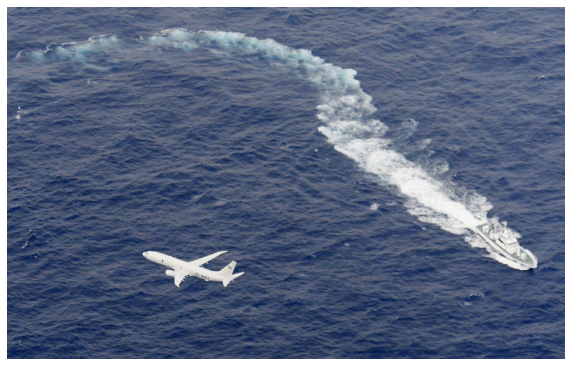

In [53]:
img_path = os.path.join(test_fighter_dir, '00000793.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 646.5, 403.5, -0.5)

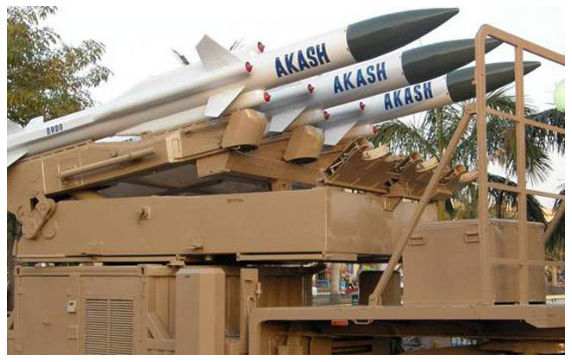

In [54]:
img_path = os.path.join(test_missile_dir, '00000706.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)